In [10]:
import pandas as pd
import numpy as np
import glob #lets us 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df_list = []
file_pattern = "20*.csv"

file_list = glob.glob(file_pattern)

# Filter out files that do not match the exact year pattern
filtered_file_list = [file for file in file_list if not re.search(r'_\w+', os.path.basename(file))]

for file in filtered_file_list:
    # Extract the year from the filename (e.g., '2015.csv' -> '2015')
    year = os.path.basename(file).split('.')[0]

    # Read the CSV file with the second row as the header
    curr = pd.read_csv(file, header=1)
    
    # Add a column with the extracted year
    curr["Year"] = year
    
    # Drop columns where all values are NaN
    curr = curr.dropna(axis=1, how='all')
    
    # Drop rows where the 'Rk' column has NaN values
    curr = curr.dropna(subset=['Rk'])

    # Append the DataFrame to the list
    df_list.append(curr)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True).sort_values(by = "Year", ascending = False)


In [16]:
combined_df

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Arena,Attend.,Attend./G,Year
181,2.0,Oklahoma City Thunder*,23.4,57.0,25.0,58,24,7.41,-0.05,7.36,...,21.1,0.198,0.530,13.6,73.8,0.202,Paycom Center,715509.0,17451.0,2024
196,17.0,Sacramento Kings,26.4,46.0,36.0,45,37,1.74,0.55,2.29,...,24.5,0.171,0.555,12.5,78.4,0.213,Golden 1 Center,735015.0,17927.0,2024
180,1.0,Boston Celtics*,28.2,64.0,18.0,66,16,11.34,-0.60,10.75,...,24.9,0.180,0.523,10.8,76.3,0.145,TD Garden,785396.0,19156.0,2024
208,29.0,Portland Trail Blazers,24.1,21.0,61.0,20,62,-9.02,0.74,-8.29,...,27.5,0.181,0.558,12.8,74.0,0.216,Moda Center,751395.0,18327.0,2024
207,28.0,Washington Wizards,24.9,15.0,67.0,20,62,-9.29,0.00,-9.29,...,20.0,0.169,0.562,12.0,72.5,0.201,Capital One Arena,692851.0,16899.0,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,25.0,Sacramento Kings,26.0,29.0,53.0,31,51,-3.71,0.64,-3.07,...,26.5,0.276,0.507,11.8,75.2,0.200,Sleep Train Arena,680049.0,16587.0,2015
235,26.0,Orlando Magic,24.3,25.0,57.0,25,57,-5.72,-0.15,-5.87,...,23.1,0.168,0.514,13.6,76.0,0.210,Amway Center,688194.0,16785.0,2015
236,27.0,Los Angeles Lakers,27.0,21.0,61.0,23,59,-6.84,0.67,-6.17,...,25.4,0.204,0.518,12.1,76.3,0.231,STAPLES Center,768244.0,18738.0,2015
237,28.0,Minnesota Timberwolves,24.4,16.0,66.0,19,63,-8.79,0.79,-8.00,...,26.6,0.240,0.537,13.9,71.6,0.187,Target Center,595652.0,14416.0,2015


In [17]:
champions = {'2024': 'Boston Celtics*',
 '2023': 'Denver Nuggets*',
 '2022': 'Golden State Warriors*',
 '2021': 'Milwaukee Bucks*',
 '2020': 'Los Angeles Lakers*',
 '2019': 'Toronto Raptors*',
 '2018': 'Golden State Warriors*',
 '2017': 'Golden State Warriors*',
 '2016': "Cleveland Cavaliers*",
 '2015': 'Golden State Warriors*'}

combined_df['Team'] = combined_df['Team'].str.strip()
combined_df['Won Championship'] = combined_df.apply(lambda row: 1 if champions.get(row['Year']) == row['Team'] else 0, axis = 1)

winners = combined_df[combined_df['Won Championship'] == 1]
winners.head(10)

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Arena,Attend.,Attend./G,Year,Won Championship
180,1.0,Boston Celtics*,28.2,64.0,18.0,66,16,11.34,-0.60,10.75,...,0.180,0.523,10.8,76.3,0.145,TD Garden,785396.0,19156.0,2024,1
65,6.0,Denver Nuggets*,26.6,53.0,29.0,49,33,3.33,-0.29,3.04,...,0.194,0.543,12.2,76.4,0.201,Ball Arena,788635.0,19235.0,2023,1
94,5.0,Golden State Warriors*,27.6,53.0,29.0,55,27,5.54,-0.02,5.52,...,0.181,0.509,13.0,78.7,0.201,Chase Center,740624.0,18064.0,2022,1
33,4.0,Milwaukee Bucks*,28.1,46.0,26.0,48,24,5.89,-0.32,5.57,...,0.177,0.536,11.5,79.7,0.157,Fiserv Forum,64780.0,1799.0,2021,1
4,5.0,Los Angeles Lakers*,29.5,52.0,19.0,48,23,5.79,0.49,6.28,...,0.201,0.515,14.1,78.8,0.205,STAPLES Center,588907.0,18997.0,2020,1
122,3.0,Toronto Raptors*,27.3,58.0,24.0,56,26,6.09,-0.60,5.49,...,0.198,0.509,13.1,77.1,0.190,Scotiabank Arena,812822.0,19825.0,2019,1
152,3.0,Golden State Warriors*,28.8,58.0,24.0,56,26,5.98,-0.19,5.79,...,0.195,0.504,12.6,76.3,0.186,Oracle Arena,803436.0,19596.0,2018,1
270,1.0,Golden State Warriors*,28.2,67.0,15.0,67,15,11.63,-0.28,11.35,...,0.204,0.486,13.5,74.9,0.198,Oracle Arena,803436.0,19596.0,2017,1
243,4.0,Cleveland Cavaliers*,28.1,57.0,25.0,57,25,6.00,-0.55,5.45,...,0.194,0.496,12.6,78.5,0.205,Quicken Loans Arena,843042.0,20562.0,2016,1
210,1.0,Golden State Warriors*,26.6,67.0,15.0,65,17,10.10,-0.09,10.01,...,0.184,0.470,14.3,74.5,0.217,Oracle Arena,803436.0,19596.0,2015,1


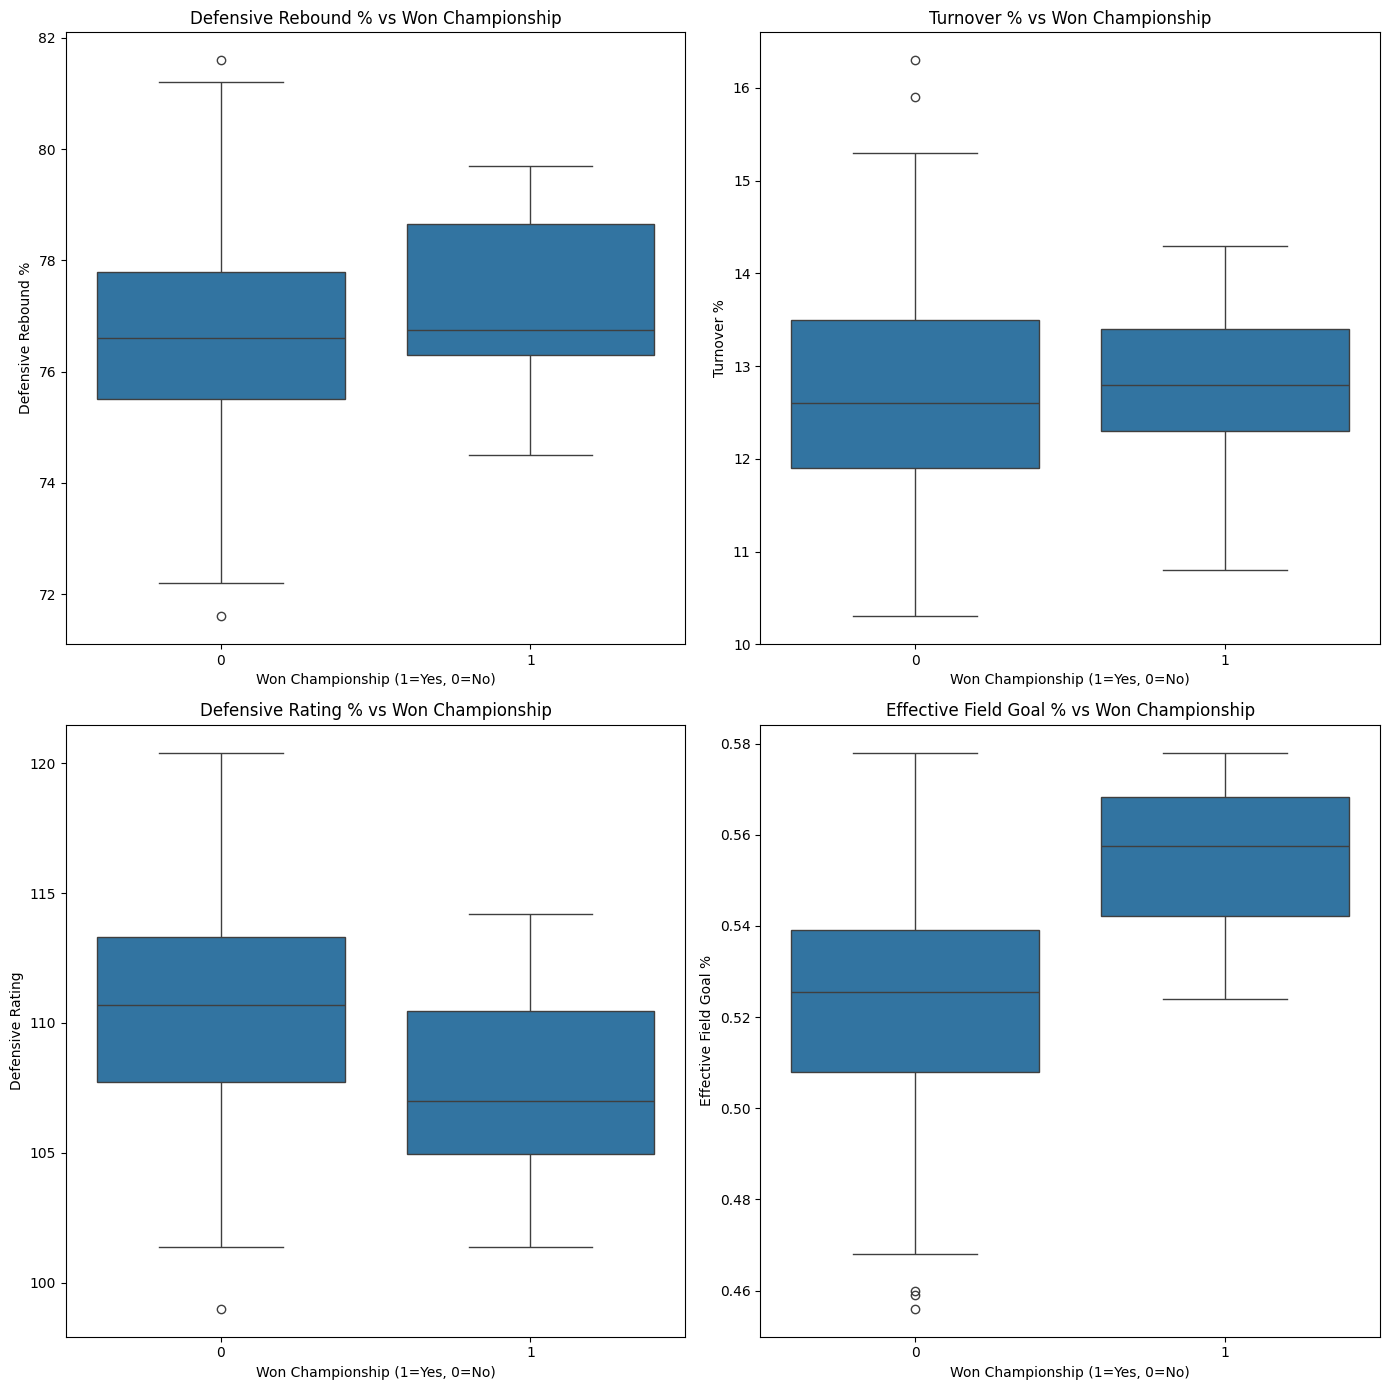

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
df = combined_df

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot 1: Defensive Rebound % vs Won Championship
sns.boxplot(x='Won Championship', y='DRB%', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Defensive Rebound % vs Won Championship')
axes[0, 0].set_xlabel('Won Championship (1=Yes, 0=No)')
axes[0, 0].set_ylabel('Defensive Rebound %')

# Plot 2: Turnover % vs Won Championship
sns.boxplot(x='Won Championship', y='TOV%.1', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Turnover % vs Won Championship')
axes[0, 1].set_xlabel('Won Championship (1=Yes, 0=No)')
axes[0, 1].set_ylabel('Turnover %')

# Plot 3: Defensive Rating % vs Won Championship
sns.boxplot(x='Won Championship', y='DRtg', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Defensive Rating % vs Won Championship')
axes[1, 0].set_xlabel('Won Championship (1=Yes, 0=No)')
axes[1, 0].set_ylabel('Defensive Rating')

# Plot 4: Effective Field Goal % vs Won Championship
sns.boxplot(x='Won Championship', y='eFG%', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Effective Field Goal % vs Won Championship')
axes[1, 1].set_xlabel('Won Championship (1=Yes, 0=No)')
axes[1, 1].set_ylabel('Effective Field Goal %')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
plt.figure(figsize = (8, 6))